In [36]:
import datetime
import fmt
import inst
import lin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from swap import Swap, priceSwap

# Problem 1
Using the provided historical CMT dataset and assuming the following zero rate term structure and assuming all rates are continuously compounding

In [2]:
cmturl = "https://raw.githubusercontent.com/yadongli/nyumath2048/master/data/cmt.csv"
cmt_rates = pd.read_csv(cmturl, parse_dates=[0], index_col=[0])*.01
cmt_rates.to_csv('cmt_rates.csv')

In [3]:
cmt_rates = pd.read_csv('cmt_rates.csv').set_index('Unnamed: 0')
t = np.array(list(map(float, cmt_rates.columns)))
r = cmt_rates.iloc[-1, :].values

fmt.displayDF(pd.DataFrame(r, index=t, columns=['Zero Rate (%)']).T*100, fmt="4g")


,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0
Zero Rate (%),0.01,0.1,0.26,0.73,1.19,1.75,2.07,2.25,2.54


Hints
* you can use the swap.py library from last homework to price swaps.
* please pay attention to the compounding, there are multiple compounding in this problem: all the zero rates are continuously compounded, the swaps pays coupon semi-annually, therefore the par swap quotes should be computed using the correct coupon frequency. The first deposit is quoted by yield (zero rate), which is countinuously compounded.
* The 3M deposit is equivalent to a 3M swap in risk profile, therefore, you may replace the 3M deposit by a quarterly par swap maturing at 3M as the first benchmark instruments during the bootstrap. It may ease the coding, as you can re-use the same swap pricer. But beware the par swap rate is different from continuous compounded zero rate, thus a proper conversion is required.

##  Part 1
Use the tension spline routine from previoius homework to build a tension spline of zero rate term structure $r(t)$ with $\lambda = 5$, you can assume $r(0) = 0$ if needed. Note that we are interpolating the zero rate instead of the cumulative yield here.

,0,1
0,0.2500,1.0000
1,0.5000,0.9995
2,1.0000,0.9974
3,2.0000,0.9855
4,3.0000,0.9649
5,5.0000,0.9162
6,7.0000,0.8651
7,10.0000,0.7985
8,20.0000,0.6017


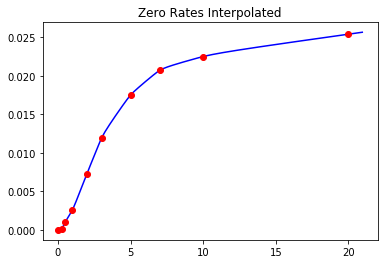

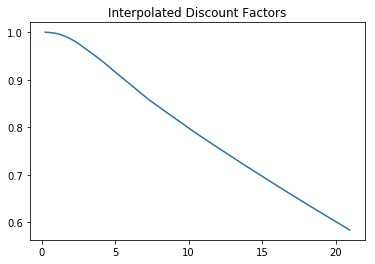

In [7]:
lbd = 5.
zero_curve = lin.RationalTension(lbd)
build_t = np.append(np.array([0]), t)
build_r = np.append(np.array([0]), r)
zero_curve.build(build_t, build_r)
t1d = np.arange(0.25, 21, 0.1)

f = plt.figure()
s = f.add_subplot('111')
s.plot(t1d, zero_curve(t1d), 'b-', build_t, build_r, 'ro')
plt.title('Zero Rates Interpolated');

f = plt.figure()
s = f.add_subplot('111')
s.plot(t1d, np.exp(-zero_curve(t1d) * t1d))
plt.title("Interpolated Discount Factors");
calculated_discount_factors = np.exp(-zero_curve(t) * t)
fmt.displayDF(pd.DataFrame(np.array([t, calculated_discount_factors]).T))

## Part 2
Suppose the liquid market securities (the benchmarks) are 3M deposit (equivalent to zero coupon bond), and swaps paying semi-annual coupons with maturities matching the CMT quotes tenors;  use the curve you built to price these benchmark securities, assuming the deposits are quoted by the continous yield (zero rate) and swaps are quoted in break even spreads (par swap spreads).

,Term,Par Rate
0,0.2500,0.0100
1,0.5000,0.1000
2,1.0000,0.2601
3,2.0000,0.7292
4,3.0000,1.1856
5,5.0000,1.7350
6,7.0000,2.0444
7,10.0000,2.2200
8,20.0000,2.4884


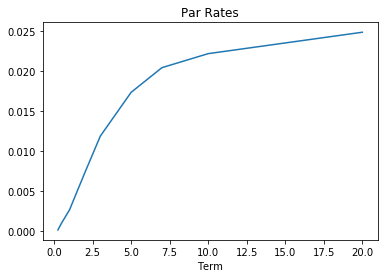

In [8]:
def get_par_from_zero(swap_freq, zero_rate_curve, swap_maturity):
    swap_freq = 2 if swap_maturity >= 0.5 else 4
    ts = np.arange(1./swap_freq, swap_maturity + 1e-6, 1./swap_freq)
    non_exp = zero_curve(ts)*ts
    disc = np.exp(-non_exp)
    pv01 = np.sum(disc)/swap_freq
    par = (1.-disc[-1])/pv01
    return par

pars = np.array([get_par_from_zero(2, zero_curve, term) for term in t])
par_table = pd.DataFrame([t, pars*100], index=['Term', 'Par Rate']).T
fmt.displayDF(par_table)
f = plt.figure()
s = f.add_subplot('111')
s.plot(t, pars);
plt.title('Par Rates');
plt.xlabel('Term');

## Part 3
use your bootstrap functions from the previous homework/lecture to bootstrap the zero rate curve from benchmark quotes from #2, show that the resulting curve is identical to the curve from #1. 

,Bootstrapped Discount Factor,Original Discount Factor
Term,,
0.2500,1.0000,1.0000
0.5000,0.9995,0.9995
1.0000,0.9974,0.9974
2.0000,0.9855,0.9855
3.0000,0.9649,0.9649
5.0000,0.9162,0.9162
7.0000,0.8652,0.8651
10.0000,0.7986,0.7985
20.0000,0.6015,0.6017


,Bootstrapped Zero Rate,Original Zero Rate
Term,,
0.2500,0.0001,0.0001
0.5000,0.0010,0.0010
1.0000,0.0026,0.0026
2.0000,0.0073,0.0073
3.0000,0.0119,0.0119
5.0000,0.0175,0.0175
7.0000,0.0207,0.0207
10.0000,0.0225,0.0225
20.0000,0.0254,0.0254


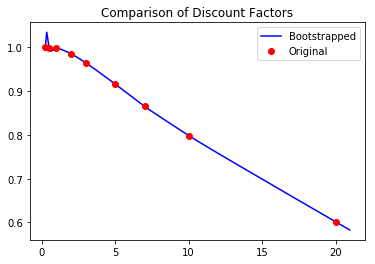

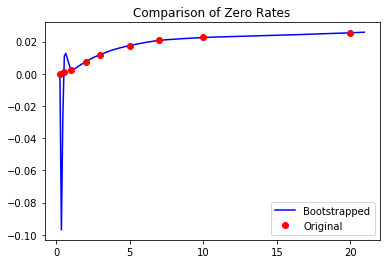

In [10]:
def y2pv(swap, curve):
    discf = lambda ts: np.exp(-curve(ts)*ts)
    return priceSwap(swap, curve)


bm_swaps = {Swap(m, c, 4 if i==0 else 2): 0 for i, (m, c) in enumerate(zip(t, pars))}
bootstrapped, e = inst.iterboot(bm_swaps, y2pv, lbd=5, x0=0, bds=[-1, 2], make_curve=lin.RationalTension, its=10)
fmt.displayDF(pd.DataFrame(np.array([t, bootstrapped(t), calculated_discount_factors]).T, columns=['Term', 'Bootstrapped Discount Factor', 'Original Discount Factor']).set_index('Term'))

fmt.displayDF(pd.DataFrame(np.array([t, -t**(-1) * np.log(bootstrapped(t)), r]).T, columns=['Term', 'Bootstrapped Zero Rate', 'Original Zero Rate']).set_index('Term'))


f = plt.figure()
s = f.add_subplot('111')
s.plot(t1d, bootstrapped(t1d), 'b-', label='Bootstrapped')
s.plot(t, calculated_discount_factors, 'ro', label='Original')
plt.title('Comparison of Discount Factors')
plt.legend()

f = plt.figure()
s = f.add_subplot('111')
s.plot(t1d, -t1d**(-1) * np.log(bootstrapped(t1d)), 'b-', label='Bootstrapped')
s.plot(t, zero_curve(t), 'ro', label='Original')
plt.title('Comparison of Zero Rates')
plt.legend();


So as we can see here, although these are not _identical_ figures, there is a minimal degree of error present, with only the 7Y, 10Y and 20Y terms showing any error in the fourth significant digit, and the others not even showing that much error. The only disquieting aspect is the spike in the discount factor graph.

## Part 4
You have an aged receiver swap (receiving fixed) on the book with $100M notional, 6Y of remaining maturity and 5% semi-annual fixed coupon. Compute its deltas and hedge notionals to the benchmark instruments by bumping the market quotes of benchmark instruments (ie, deposit and swaps) and re-bootstrapping the IR curve, record the computation time for hedge notionals.

In [42]:
import itertools

def calculate_present_value(swap, notional, discount_curve):
    payout_times = np.arange(1./swap.freq, swap.maturity + 1e-6/swap.freq, 1./swap.freq)
    discount_factors = discount_curve(payout_times)
    return np.sum(notional*swap.coupon*discount_factors) + discount_factors[-1]*notional


def calculate_instrument_deltas(benchmarks, swap, notional, its=10):
    deltas = []
    unadjusted_curve, _ = inst.iterboot(dict(zip(benchmarks, itertools.repeat(0))), y2pv, lbd=5, x0=0, bds=[-1, 2], make_curve=lin.RationalTension, its=its)
    base_pv = calculate_present_value(swap, notional, unadjusted_curve)

    for bumper in benchmarks:
        bumped_benchmarks = {b if b is not bumper else Swap(b.maturity, b.coupon+1e-4, b.freq): 0 for b in benchmarks}
        bumped_curve, _ = inst.iterboot(bumped_benchmarks, y2pv, lbd=5, x0=0, bds=[-1, 2], make_curve=lin.RationalTension, its=its)
        bumped_pv = calculate_present_value(swap, notional, bumped_curve)
        deltas.append((bumped_pv - base_pv) / (1e-4))

    return np.array(deltas)


benchmarks = sorted(bm_swaps, key=lambda x: x.maturity)

swap = Swap(6, 0.05, 2)

notional = 1e8
deltas = calculate_instrument_deltas(benchmarks, swap, notional)
fmt.displayDF(pd.DataFrame(np.array([np.array([bm.maturity for bm in benchmarks]), deltas]).T,
                           columns=['$T_q$', '$\partial v / \partial q$']))



def calculate_hedge_notionals_using_benchmarks(benchmarks, swap, notional, its=10):
    unadjusted_curve, _ = inst.iterboot(dict(zip(benchmarks, itertools.repeat(0))), y2pv, lbd=5, x0=0, bds=[-1, 2], make_curve=lin.RationalTension, its=its)

    bumped_swap_deltas = []
    bumped_benchmark_deltas = []

    unbumped_swap_pv = calculate_present_value(swap, notional, unadjusted_curve)
    unbumped_benchmark_pvs = [calculate_present_value(bm, 1, unadjusted_curve) for bm in benchmarks]

    for bumper in benchmarks:
        bumped_benchmarks = {b if b is not bumper else Swap(b.maturity, b.coupon+1e-4, b.freq): 0 for b in benchmarks}
        bumped_curve, _ = inst.iterboot(bumped_benchmarks,
                                        y2pv,
                                        lbd=5,
                                        x0=0,
                                        bds=[-1, 2],
                                        make_curve=lin.RationalTension,
                                        its=its)
        bumped_swap_deltas.append((calculate_present_value(swap, notional, bumped_curve) - unbumped_swap_pv)/1e-4)
        bumped_benchmark_deltas.append(np.array([
            (calculate_present_value(bm, 1, bumped_curve) - bm_swap_pv) / 1e-4
            for bm, bm_swap_pv in zip(benchmarks, unbumped_benchmark_pvs)
        ]))

    return np.array(bumped_swap_deltas).dot(np.linalg.inv(np.array(bumped_benchmark_deltas)))

t1 = datetime.datetime.now()
notionals = calculate_hedge_notionals_using_benchmarks(benchmarks, swap, notional)
t2 = datetime.datetime.now()
calculation_time = (t2 - t1).seconds + 1e-6*(t2-t1).microseconds
print(f"Calculation Time: {calculation_time} s")

fmt.displayDF(pd.DataFrame(np.array([np.array([bm.maturity for bm in benchmarks]), notionals]).T,
                           columns=['$T_q$', '$h_0$']),
              fmt='2f')

        


,$T_q$,$\partial v / \partial q$
0,0.2500,"-15,408.4775"
1,0.5000,"-1,708,299.2446"
2,1.0000,"-5,913,488.1458"
3,2.0000,"-15,120,611.7803"
4,3.0000,"-24,016,952.8148"
5,5.0000,"-336,667,445.7607"
6,7.0000,"-350,112,892.9430"
7,10.0000,"15,213,145.2680"
8,20.0000,"-230,621.5650"


Calculation Time: 3.91372 s


,$T_q$,$h_0$
0,0.25,"61,632.38"
1,0.50,"3,416,770.08"
2,1.00,"5,913,054.94"
3,2.00,"7,546,809.43"
4,3.00,"7,975,226.22"
5,5.00,"68,126,888.58"
6,7.00,"49,689,456.60"
7,10.00,"-5,003,753.68"
8,20.00,"-566,480.76"


## Part 5
Suppose your system only computes the risks to the zero rates, compute the risk of the aged trade to zero rates, and the Jacobian matrix and use them to compute the hedge notionals, compare the results and computation time to the previous step. 

**Student Note**: I'm going to use the approach outlined in Anderson & Piterbarg 6.4.2.: piecewise bump the forward curve. I'm modifying the approach to directly bump the zero curve instead.

In [53]:
np.exp(-zero_curve(t1d) * t1d)

def create_bumped_discount_curve(zero_curve, upper, lower, bump_size=1e-4):
    def bumped_curve(t):
        res = zero_curve(t)

        if isinstance(res, np.ndarray):
            return np.exp(np.array([val+bump_size if lower <= tt < upper else val for tt, val in zip(t, res)]) * t)
        else:
            return (res + (1e-4 if lower <= tt <= upper else 0)) * t

    return bumped_curve


def calculate_hedge_notionals_using_bumped_zero(unadjusted_zero_curve, benchmarks, swap, notional):
    maturities = [0] + [bm.maturity for bm in benchmarks]

    bumped_swap_deltas = []
    bumped_benchmark_deltas = []

    unadjusted_discount_curve = create_bumped_discount_curve(unadjusted_zero_curve, 0, 1, 0)
    unbumped_swap_pv = calculate_present_value(swap, notional, unadjusted_discount_curve)
    unbumped_benchmark_pvs = [calculate_present_value(bm, 1, unadjusted_discount_curve) for bm in benchmarks]

    for lower, upper in zip(maturities, maturities[1:]):
        bumped_curve = create_bumped_discount_curve(unadjusted_zero_curve, upper, lower)
        bumped_swap_deltas.append((calculate_present_value(swap, notional, bumped_curve) - unbumped_swap_pv)/1e-4)
        bumped_benchmark_deltas.append(np.array([
            (calculate_present_value(bm, 1, bumped_curve) - bm_swap_pv) / 1e-4
            for bm, bm_swap_pv in zip(benchmarks, unbumped_benchmark_pvs)
        ]))

    return np.array(bumped_swap_deltas).dot(np.linalg.inv(np.array(bumped_benchmark_deltas)))


t1 = datetime.datetime.now()
notionals = calculate_hedge_notionals_using_bumped_zero(zero_curve, benchmarks, swap, notional)
t2 = datetime.datetime.now()
calculation_time = (t2 - t1).seconds + 1e-6*(t2-t1).microseconds
print(f"Calculation Time: {calculation_time} s")

fmt.displayDF(pd.DataFrame(np.array([np.array([bm.maturity for bm in benchmarks]), notionals]).T,
                           columns=['$T_q$', '$h_0$']),
              fmt='2f')


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.50034376e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.00762957e-01 1.30100754e-03 3.64809310e-03
  5.93093291e-03 8.67949207e-03 1.02275057e-02 1.11057417e-02
  1.24484159e-02]
 [0.00000000e+00 0.00000000e+00 1.00526107e+00 1.83315730e-02
  2.98027837e-02 4.36142221e-02 5.13929506e-02 5.58060633e-02
  6.25529663e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.04441785e+00
  5.44284145e-02 7.96520546e-02 9.38582397e-02 1.01917847e-01
  1.14239623e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.14636622e+00 2.75321508e-01 3.24425932e-01 3.52284387e-01
  3.94875253e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.55328145e+00 5.25117244e-01 5.70209062e-01
  6.39146826e-01]
 [0.00

LinAlgError: Singular matrix

## Problem 2

Following what you have done from the first problem, take the zero rates as fundamental risk factors in the market, and the aged bespoke swap:

## Part 1
Suppose only 1Y, 5Y and 10Y IR swaps are liquid, devise the best hedging portfolio for the aged swap that minimizes the L-2 norm of the risks.

## Part 2
Repeat step 1, but minimize the variance of the hedged portfolio instead, you can estimate the covariance matrix from the historical data.

Show the effectiveness of your hedging portfolio.

Hint: be careful on whether you should use the covariance of levels or changes of rates.

## (Extra credit) Problem 4 
The Brownian bridge method can be easily extended to multi-dimensional correlated Brownian motions. Assuming we have two browniam motion $x(t), y(t)$ with a correlation of 50%,

## Part 1
Write a program to construct correlated Brownian Bridge from the given terminal values, correlation matrix and time increments, note that here you need to draw correlated Gaussian random numbers to perserve the correlation of the Brownian Bridge increments.

In [ ]:
def create_brownian_bridge(terminal_values, correlation_matrix, dt):
    obs = np.random.normal(0, 1, (len(correlation_matrix), int(1/dt)))
    c = np.linalg.cholesky(correlation_matrix)
    samples = c.dot(obs)
    samples = np.cumsum(samples, 1)
    t = np.arange(0, 1, dt)
    return np.array([
        p - (p[-1] - terminal)*t for terminal, p in zip(terminal_values, samples)
    ])
    
rho = np.array([
    [1, 0.5],
    [0.5, 1],
])
pd.DataFrame(create_brownian_bridge([2, 3], rho, 0.01)).T.rename(columns={0: '$x(t)$', 1: '$y(t)$'}).plot();

This was written assuming $\mu=0$ and $\sigma=1$. At such conditions, the correlation and covariance matrices are equivalent.

## Part 2
Draw multiple paths from different terminal values and verify that the correlation of the increments of your Brownian Bridge is indeed 50%. Note that the terminal values can be drawn directly using the covariance matrix, which is known. 

In [ ]:
correlation = np.array([
    pd.DataFrame(create_brownian_bridge([2, 4], rho, 0.01).T).diff().corr().iloc[0,1]
    for _ in range(1000)
])
print('Mean of the Correlation of the Increments', correlation.mean())
print('Std Deviation', correlation.std())
tt = 0.01
x = []

for _ in range(100):
    for xx in create_brownian_bridge([2, 4], np.array([[1,0.5],[0.5,1]]), tt):
        x.append(xx)

dt = np.arange(0, 1, tt)
x = np.array(x)

xt = x[::2]
yt = x[1::2]

plt.figure(figsize=[12, 4])
s = plt.subplot(1, 2, 1)
s.plot(dt, xt[:3].T)
s.plot(dt, np.std(xt, 0))
plt.title('$x(t)$');

s = plt.subplot(1, 2, 2)
s.plot(dt, yt[:3].T)
s.plot(dt, np.std(yt, 0))
plt.title('$y(t)$');

## Part 3
Suppose that you forgot about the correlation and used independent Gaussian random numbers in step 1, and have drawn the Brownian Bridges using correlated terminal values, but independent increments; Plot the resulting terminal value correlation between $\rho\left(x(t), y(t)\right)$ of the resulting Brownian Bridge over time $t$, explain your observation.

In [ ]:
tt = 0.01
x = []

for _ in range(100):
    for xx in create_brownian_bridge([2, 4], np.array([[1,0],[0,1]]), tt):
        x.append(xx)

dt = np.arange(0, 1, tt)
x = np.array(x)

xt = x[::2]
yt = x[1::2]

plt.figure(figsize=[12, 4])
s = plt.subplot(1, 2, 1)
s.plot(dt, xt[:3].T)
s.plot(dt, np.std(xt, 0))
plt.title('$x(t)$');

s = plt.subplot(1, 2, 2)
s.plot(dt, yt[:3].T)
s.plot(dt, np.std(yt, 0))
plt.title('$y(t)$');

As we can see, the terminal value correlation looks essentially the same for correlated and uncorrelated data. This is easy to explain -- since the termination points are fixed, we know that the end of the paths must have $\sigma = 0$. Similarly, since the starting points are all the same -- 0 -- $\sigma$ at the very beginning will also be 0. Regardless of the correlation of the steps themselves, the middle of the interval will always have the greatest room for standard deviation.